In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

In [4]:
!unzip wider_face_split.zip
!unzip WIDER_train.zip
!unzip WIDER_val.zip

unzip:  cannot find or open wider_face_split.zip, wider_face_split.zip.zip or wider_face_split.zip.ZIP.


unzip:  cannot find or open WIDER_train.zip, WIDER_train.zip.zip or WIDER_train.zip.ZIP.
unzip:  cannot find or open WIDER_val.zip, WIDER_val.zip.zip or WIDER_val.zip.ZIP.


In [5]:
def parse_widerface_annotations(annotation_path, img_dir):
    with open(annotation_path, 'r') as f:
        lines = f.read().splitlines()

    images = []
    labels = []
    i = 0
    total_skipped = 0

    while i < len(lines):
        filename = lines[i].strip()
        i += 1

        if i >= len(lines):
            break

        try:
            num_boxes = int(lines[i].strip())
        except ValueError:
            print(f"Skipping invalid entry at line {i}: {filename}")
            total_skipped += 1
            continue

        i += 1
        boxes = []
        for _ in range(num_boxes):
            if i >= len(lines):
                break
            parts = lines[i].strip().split()
            if len(parts) < 4:
                i += 1
                continue
            try:
                x, y, w, h = map(int, parts[:4])
                boxes.append([x, y, x + w, y + h])
            except ValueError:
                pass
            i += 1

        if len(boxes) > 0:
            img_path = os.path.join(img_dir, filename)
            images.append(img_path)
            labels.append(boxes)

    print(f"Parsed {len(images)} images, skipped {total_skipped} invalid entries.")
    return images, labels


train_img_dir = "dataset/WIDER_train/images"
val_img_dir = "dataset/WIDER_val/images"

train_annot = "dataset/wider_face_split/wider_face_train_bbx_gt.txt"
val_annot = "dataset/wider_face_split/wider_face_val_bbx_gt.txt"

train_imgs, train_boxes = parse_widerface_annotations(train_annot, train_img_dir)
val_imgs, val_boxes = parse_widerface_annotations(val_annot, val_img_dir)


Skipping invalid entry at line 10424: 0 0 0 0 0 0 0 0 0 0
Skipping invalid entry at line 86539: 0 0 0 0 0 0 0 0 0 0
Skipping invalid entry at line 133394: 0 0 0 0 0 0 0 0 0 0
Skipping invalid entry at line 145714: 0 0 0 0 0 0 0 0 0 0
Parsed 12876 images, skipped 4 invalid entries.
Parsed 3226 images, skipped 0 invalid entries.


In [6]:
import torch
import torch.nn as nn

class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=1):  # S: grid size, B: boxes, C: classes (only face = 1)
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 128, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 256, 1), nn.ReLU(),
            nn.Conv2d(256, 512, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * S * S, 4096), nn.ReLU(),
            nn.Linear(4096, S * S * (C + B * 5))  # (C + B*5) per grid cell
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class WiderFaceDataset(Dataset):
    def __init__(self, image_paths, boxes, S=7, B=2, C=1, image_size=224):
        self.image_paths = image_paths
        self.boxes = boxes
        self.S = S
        self.B = B
        self.C = C
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size))
        ])

    def __len__(self):
        return len(self.image_paths)

    def encode(self, boxes, img_w, img_h):
        label = torch.zeros((self.S, self.S, self.C + self.B * 5))
        for box in boxes:
            x1, y1, x2, y2 = box
            cx = (x1 + x2) / 2 / img_w
            cy = (y1 + y2) / 2 / img_h
            w = (x2 - x1) / img_w
            h = (y2 - y1) / img_h

            i = int(cx * self.S)
            j = int(cy * self.S)

            if i >= self.S or j >= self.S:
                continue

            label[j, i, 0] = 1  # objectness
            label[j, i, 1:5] = torch.tensor([cx, cy, w, h])
        return label

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        boxes = self.boxes[idx]
        label = self.encode(boxes, w, h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.image_size, self.image_size))
        img = torch.tensor(img / 255.0).permute(2, 0, 1).float()
        return img, label


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLOv1().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset = WiderFaceDataset(train_imgs[:1000], train_boxes[:1000])
val_dataset = WiderFaceDataset(val_imgs[:200], val_boxes[:200])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

for epoch in range(50):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        preds = model(imgs)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


100%|██████████| 125/125 [00:12<00:00,  9.78it/s]


Epoch 1, Loss: 0.0188


100%|██████████| 125/125 [00:12<00:00,  9.63it/s]


Epoch 2, Loss: 0.0169


100%|██████████| 125/125 [00:12<00:00,  9.91it/s]


Epoch 3, Loss: 0.0152


100%|██████████| 125/125 [00:12<00:00,  9.73it/s]


Epoch 4, Loss: 0.0146


100%|██████████| 125/125 [00:12<00:00,  9.72it/s]


Epoch 5, Loss: 0.0140


100%|██████████| 125/125 [00:12<00:00,  9.81it/s]


Epoch 6, Loss: 0.0134


100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Epoch 7, Loss: 0.0128


100%|██████████| 125/125 [00:13<00:00,  9.50it/s]


Epoch 8, Loss: 0.0121


100%|██████████| 125/125 [00:13<00:00,  9.54it/s]


Epoch 9, Loss: 0.0118


100%|██████████| 125/125 [00:13<00:00,  9.43it/s]


Epoch 10, Loss: 0.0109


100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Epoch 11, Loss: 0.0103


100%|██████████| 125/125 [00:13<00:00,  9.33it/s]


Epoch 12, Loss: 0.0092


100%|██████████| 125/125 [00:12<00:00,  9.98it/s]


Epoch 13, Loss: 0.0083


100%|██████████| 125/125 [00:12<00:00, 10.03it/s]


Epoch 14, Loss: 0.0073


100%|██████████| 125/125 [00:12<00:00,  9.92it/s]


Epoch 15, Loss: 0.0060


100%|██████████| 125/125 [00:12<00:00, 10.08it/s]


Epoch 16, Loss: 0.0047


100%|██████████| 125/125 [00:12<00:00, 10.01it/s]


Epoch 17, Loss: 0.0037


100%|██████████| 125/125 [00:12<00:00, 10.10it/s]


Epoch 18, Loss: 0.0029


100%|██████████| 125/125 [00:12<00:00, 10.04it/s]


Epoch 19, Loss: 0.0021


100%|██████████| 125/125 [00:12<00:00, 10.07it/s]


Epoch 20, Loss: 0.0015


100%|██████████| 125/125 [00:12<00:00,  9.94it/s]


Epoch 21, Loss: 0.0012


100%|██████████| 125/125 [00:12<00:00, 10.12it/s]


Epoch 22, Loss: 0.0010


100%|██████████| 125/125 [00:12<00:00,  9.83it/s]


Epoch 23, Loss: 0.0009


100%|██████████| 125/125 [00:13<00:00,  9.53it/s]


Epoch 24, Loss: 0.0008


100%|██████████| 125/125 [00:12<00:00,  9.73it/s]


Epoch 25, Loss: 0.0008


100%|██████████| 125/125 [00:12<00:00,  9.65it/s]


Epoch 26, Loss: 0.0006


100%|██████████| 125/125 [00:12<00:00,  9.69it/s]


Epoch 27, Loss: 0.0004


100%|██████████| 125/125 [00:12<00:00,  9.68it/s]


Epoch 28, Loss: 0.0004


100%|██████████| 125/125 [00:12<00:00,  9.64it/s]


Epoch 29, Loss: 0.0003


100%|██████████| 125/125 [00:13<00:00,  9.56it/s]


Epoch 30, Loss: 0.0004


100%|██████████| 125/125 [00:13<00:00,  9.55it/s]


Epoch 31, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.66it/s]


Epoch 32, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.76it/s]


Epoch 33, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.90it/s]


Epoch 34, Loss: 0.0004


100%|██████████| 125/125 [00:12<00:00,  9.86it/s]


Epoch 35, Loss: 0.0005


100%|██████████| 125/125 [00:12<00:00,  9.82it/s]


Epoch 36, Loss: 0.0005


100%|██████████| 125/125 [00:12<00:00,  9.81it/s]


Epoch 37, Loss: 0.0005


100%|██████████| 125/125 [00:12<00:00,  9.87it/s]


Epoch 38, Loss: 0.0004


100%|██████████| 125/125 [00:12<00:00, 10.00it/s]


Epoch 39, Loss: 0.0003


100%|██████████| 125/125 [00:13<00:00,  9.61it/s]


Epoch 40, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.74it/s]


Epoch 41, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.79it/s]


Epoch 42, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.76it/s]


Epoch 43, Loss: 0.0002


100%|██████████| 125/125 [00:12<00:00,  9.75it/s]


Epoch 44, Loss: 0.0002


100%|██████████| 125/125 [00:12<00:00,  9.80it/s]


Epoch 45, Loss: 0.0004


100%|██████████| 125/125 [00:12<00:00,  9.69it/s]


Epoch 46, Loss: 0.0005


100%|██████████| 125/125 [00:12<00:00,  9.78it/s]


Epoch 47, Loss: 0.0005


100%|██████████| 125/125 [00:12<00:00,  9.68it/s]


Epoch 48, Loss: 0.0004


100%|██████████| 125/125 [00:12<00:00,  9.72it/s]


Epoch 49, Loss: 0.0003


100%|██████████| 125/125 [00:12<00:00,  9.65it/s]

Epoch 50, Loss: 0.0002


In [ ]:
def visualize_prediction(img_tensor, pred, threshold=0.5):
    S = pred.shape[0]

    # Convert from CHW Tensor to HWC NumPy (0–255 uint8)
    img = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    h, w, _ = img.shape

    for i in range(S):
        for j in range(S):
            if pred[i, j, 0] > threshold:
                bx = pred[i, j, 1]
                by = pred[i, j, 2]
                bw = pred[i, j, 3]
                bh = pred[i, j, 4]

                cx = int(bx * w)
                cy = int(by * h)
                ww = int(bw * w)
                hh = int(bh * h)

                x1 = max(cx - ww // 2, 0)
                y1 = max(cy - hh // 2, 0)
                x2 = min(cx + ww // 2, w)
                y2 = min(cy + hh // 2, h)

                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


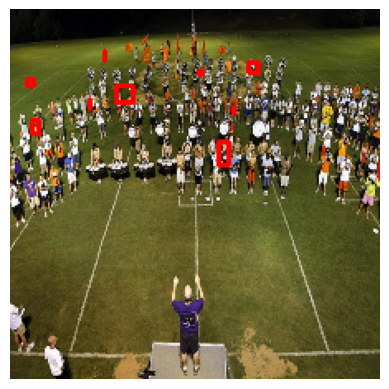

In [ ]:
model.eval()
img, _ = val_dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0].cpu()

visualize_prediction(img, pred)


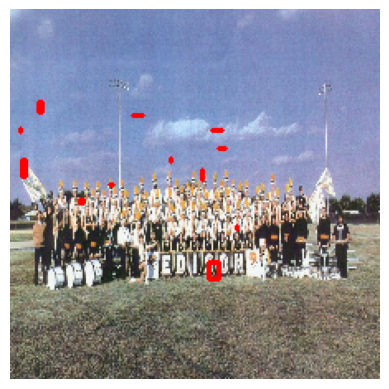

In [ ]:
# Load a different image (e.g. index 10)
img, _ = val_dataset[10]

model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0].cpu()

visualize_prediction(img, pred)


In [ ]:
def load_custom_image(path, image_size=224):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    img_tensor = torch.tensor(img / 255.0).permute(2, 0, 1).float()
    return img_tensor

custom_img = load_custom_image("images/1.jpg", image_size=224)

model.eval()
with torch.no_grad():
    pred = model(custom_img.unsqueeze(0).to(device))[0].cpu()

visualize_prediction(custom_img, pred)


NameError: name 'torch' is not defined